In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-07-15 01:43:25--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.32.248, 52.216.178.5, 52.216.213.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.32.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  44.0MB/s    in 0.3s    

2024-07-15 01:43:25 (44.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i,:] = values[:]

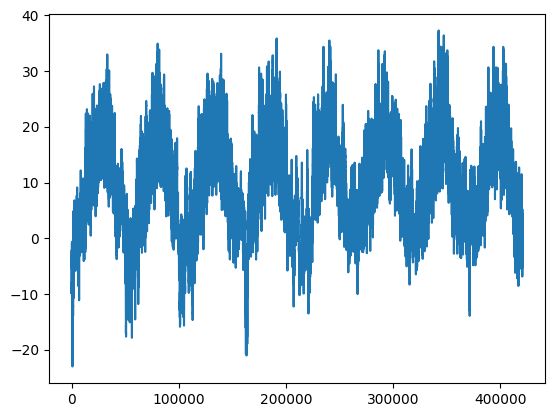

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

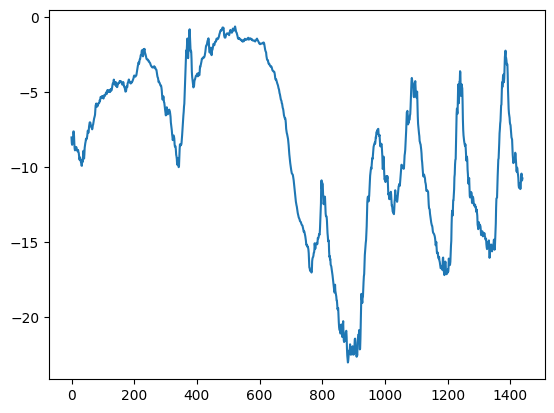

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
import keras
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data)-num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:",num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
# Assuming num_train_samples, num_val_samples, raw_data, and temperature are defined
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Calculate end_index based on raw_data length to avoid going out of bounds
train_end_index = min(num_train_samples, len(raw_data) - delay)
val_end_index = min(num_train_samples + num_val_samples, len(raw_data) - delay)
test_end_index = len(raw_data) - delay

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:train_end_index + delay],
    targets=temperature[delay:train_end_index + delay],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_end_index
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:val_end_index + delay],
    targets=temperature[delay:val_end_index + delay],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=val_end_index
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:test_end_index + delay],
    targets=temperature[delay:test_end_index + delay],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=test_end_index
)

##*FULLY CONNECTED NETWORK*

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
inputs=keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x=layers.Flatten()(inputs)
x=layers.Dense(16,activation="relu")(x)
outputs=layers.Dense(1)(x)
model=keras.Model(inputs, outputs)

callbacks= [keras.callbacks.ModelCheckpoint("jena_dense.keras",save_best_only=True)]
model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
history=model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)
model=keras.models.load_model("jena_dense.keras")
print(f"Test MAE : {model.evaluate(test_dataset)[1]:2f}")

Epoch 1/10
819/819 [==============================] - 46s 55ms/step - loss: 13.4927 - mae: 2.8491 - val_loss: 18.5246 - val_mae: 3.4553
Epoch 2/10
819/819 [==============================] - 54s 65ms/step - loss: 9.5833 - mae: 2.4343 - val_loss: 10.2463 - val_mae: 2.5372
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 8.6678 - mae: 2.3171 - val_loss: 10.4222 - val_mae: 2.5508
Epoch 4/10
819/819 [==============================] - 52s 63ms/step - loss: 8.1446 - mae: 2.2437 - val_loss: 11.1039 - val_mae: 2.6274
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 7.8303 - mae: 2.2023 - val_loss: 13.9589 - val_mae: 2.9692
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 7.5485 - mae: 2.1632 - val_loss: 10.8997 - val_mae: 2.6137
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 7.3598 - mae: 2.1360 - val_loss: 10.3677 - val_mae: 2.5429
Epoch 8/10
819/819 [==============================] - 

<function matplotlib.pyplot.show(close=None, block=None)>

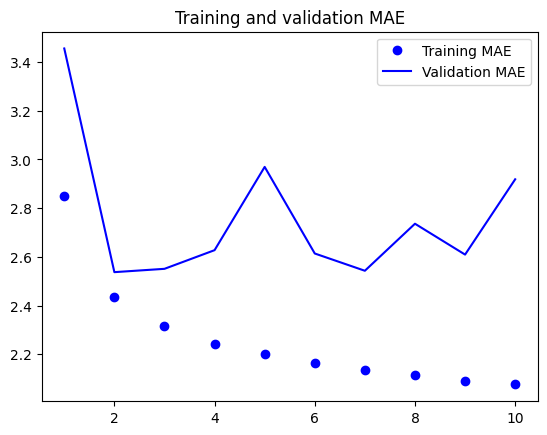

In [10]:
import matplotlib.pyplot as plt
loss=history.history["mae"]
val_loss=history.history["val_mae"]
epochs=range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training MAE")
plt.plot(epochs,val_loss,"b",label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

##*CONVOLUTIONAL LAYER*

In [11]:
inputs=keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x=layers.Conv1D(8,24,activation="relu")(inputs)
x=layers.MaxPooling1D(2)(x)
x=layers.Conv1D(8,12,activation="relu")(x)
x=layers.MaxPooling1D(2)(x)
x=layers.Conv1D(8,6,activation="relu")(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1)(x)
model=keras.Model(inputs,outputs)
callbacks=[keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)]
model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
history=model.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=callbacks)
model=keras.models.load_model("jena_conv.keras")
print(f"Test MAE : {model.evaluate(test_dataset)[1]:2f}")


Epoch 1/10
819/819 [==============================] - 78s 94ms/step - loss: 22.4305 - mae: 3.6898 - val_loss: 15.4210 - val_mae: 3.1153
Epoch 2/10
819/819 [==============================] - 79s 96ms/step - loss: 15.1317 - mae: 3.0747 - val_loss: 16.1463 - val_mae: 3.1945
Epoch 3/10
819/819 [==============================] - 80s 98ms/step - loss: 13.6599 - mae: 2.9231 - val_loss: 15.3761 - val_mae: 3.0882
Epoch 4/10
819/819 [==============================] - 80s 98ms/step - loss: 12.7597 - mae: 2.8256 - val_loss: 16.1952 - val_mae: 3.1709
Epoch 5/10
819/819 [==============================] - 88s 107ms/step - loss: 12.0647 - mae: 2.7432 - val_loss: 15.1990 - val_mae: 3.0914
Epoch 6/10
819/819 [==============================] - 85s 103ms/step - loss: 11.5369 - mae: 2.6828 - val_loss: 17.9550 - val_mae: 3.3358
Epoch 7/10
819/819 [==============================] - 80s 98ms/step - loss: 11.1146 - mae: 2.6327 - val_loss: 15.6222 - val_mae: 3.1149
Epoch 8/10
819/819 [==========================

<function matplotlib.pyplot.show(close=None, block=None)>

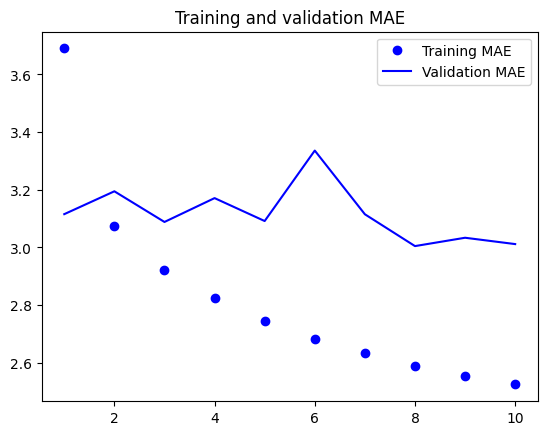

In [12]:
import matplotlib.pyplot as plt
loss=history.history["mae"]
val_loss=history.history["val_mae"]
epochs=range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training MAE")
plt.plot(epochs,val_loss,"b",label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

##Recurrent Network

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model= keras.Model(inputs,outputs)
callbacks=[keras.callbacks.ModelCheckpoint("jena_lstm.keras",save_best_only=True)]
model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
history=model.fit(train_dataset,epochs=10,validation_data=val_dataset,
                  callbacks=callbacks)
model=keras.models.load_model("jena_lstm.keras")
print(f"Test MAE : {model.evaluate(test_dataset)[1]:2f}")


Epoch 1/10
819/819 [==============================] - 125s 150ms/step - loss: 42.0427 - mae: 4.7238 - val_loss: 12.6154 - val_mae: 2.6983
Epoch 2/10
819/819 [==============================] - 124s 151ms/step - loss: 11.0592 - mae: 2.5854 - val_loss: 10.4109 - val_mae: 2.4675
Epoch 3/10
819/819 [==============================] - 124s 152ms/step - loss: 9.8905 - mae: 2.4582 - val_loss: 10.0792 - val_mae: 2.4372
Epoch 4/10
819/819 [==============================] - 104s 126ms/step - loss: 9.4190 - mae: 2.3962 - val_loss: 10.3370 - val_mae: 2.4496
Epoch 5/10
819/819 [==============================] - 108s 131ms/step - loss: 9.0203 - mae: 2.3467 - val_loss: 9.4926 - val_mae: 2.3811
Epoch 6/10
819/819 [==============================] - 105s 128ms/step - loss: 8.6987 - mae: 2.3072 - val_loss: 9.3089 - val_mae: 2.3619
Epoch 7/10
819/819 [==============================] - 108s 131ms/step - loss: 8.4657 - mae: 2.2763 - val_loss: 10.2608 - val_mae: 2.4308
Epoch 8/10
819/819 [=====================

<function matplotlib.pyplot.show(close=None, block=None)>

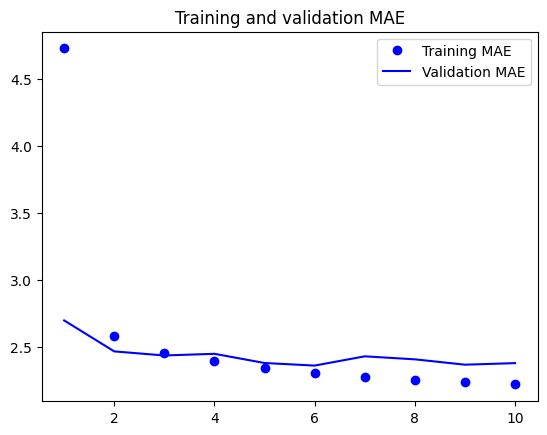

In [14]:
import matplotlib.pyplot as plt
loss=history.history["mae"]
val_loss=history.history["val_mae"]
epochs=range(1,len(loss) + 1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training MAE")
plt.plot(epochs,val_loss,"b",label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

According to my observation, the Recurrent Network is the best that I got the results for at the epoch = 2.3 the overfitting seems to get better at this point compared to the other two networks.